# News Tweets Classifier
Reference:
- https://iq.opengenus.org/text-classification-using-k-nearest-neighbors/
- https://www.geeksforgeeks.org/saving-a-machine-learning-model/

Download Dataset

In [1]:
!wget "https://github.com/bernardadhitya/news-tweet-classification/raw/master/news_tweets_labeled.csv"
!wget "https://github.com/bernardadhitya/news-tweet-classification/raw/master/preprocessor.py"

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


Import library

In [2]:
import numpy as np
import pandas as pd
import pickle
import re
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from preprocessor import Preprocessor

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
preprocessor = Preprocessor()

Import and preprocess dataset 

In [4]:
df = pd.read_csv('news_tweets_labeled.csv')
df = df[["text", "category"]]

In [5]:
sw = stopwords.words('english')

wnl = WordNetLemmatizer()
for i in range(df.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', df.loc[i, 'text'])
  review = review.lower()
  review = review.split()

  review = [wnl.lemmatize(word) for word in review if not word in sw]
  review = ' '.join(review)
  df.loc[i, 'text'] = review

In [6]:
df = preprocessor.prepare_dataset(df)

train_data = df.sample(frac=0.8, random_state=200)
test_data = df.drop(train_data.index)

Build dictionary and transform

In [7]:
# Builds a dictionary of features and transforms document to feature vectors and convert tweets to a 
# matrix of token counts (CountVectorizer)
count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(train_data['text'])

# Transform a count matrix to a normalized tf-idf representation (tf-idf transformer)
tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

Train the model and give some new tweets

In [8]:
knn = KNeighborsClassifier(n_neighbors=10, weights='distance')

# Train classifier; train_data['category'] will be having numbers assigned for each category in train data
clf = knn.fit(x_train_tfidf, train_data['category'])

# Input data to predict their classes of the given categories
tweets_new = ["Seven people have been arrested following a search of two vehicles in Hayle Cornwall police have said", 
            "RT MoneyTelegraph Your gas and electricity bills are set to increase by 36pc over the next 10 years",
            "The most common symptom of Covid19 is now a headache say experts as they warned people to get tested even if they think they are not suffering from the illness"]
# building up feature vector of input
x_new_counts = count_vect.transform(tweets_new)
# Call transform instead of fit_transform because it's already been fit
x_new_tfidf = tfidf_transformer.transform(x_new_counts)

In [9]:
# Predicting the category of input text: Will give out number of category
predicted = clf.predict(x_new_tfidf)

for tweet, category in zip(tweets_new, predicted):
  print('%r => %s' %(tweet, category))

'Seven people have been arrested following a search of two vehicles in Hayle Cornwall police have said' => others
'RT MoneyTelegraph Your gas and electricity bills are set to increase by 36pc over the next 10 years' => business
'The most common symptom of Covid19 is now a headache say experts as they warned people to get tested even if they think they are not suffering from the illness' => health


Test the model

In [10]:
# use Pipeline to add vectorizer -> transformer -> classifier all in a one compound classifier
tweet_clf = Pipeline([
  ('vect', CountVectorizer()),
  ('tfidf', TfidfTransformer()),
  ('clf', knn)
])

# Fitting train data to the pipeline
tweet_clf.fit(train_data['text'], train_data['category'])

# Test data
docs_test = test_data['text']

# Predicting test data
predicted = tweet_clf.predict(docs_test)

In [11]:
test_data_temp = preprocessor.prepare_test_dataset(test_data)

predicted_temp = tweet_clf.predict(test_data_temp['text'])

               Precision    Recall  F1 Score
business        0.975000  0.750000  0.847826
entertainment   0.805556  0.783784  0.794521
health          0.839286  0.886792  0.862385
lifestyle       0.811321  0.728814  0.767857
others          0.801205  0.801205  0.801205
politics        0.794118  0.931034  0.857143
science         0.700000  0.823529  0.756757
sport           0.933333  0.848485  0.888889
technology      1.000000  0.400000  0.571429
weather         0.909091  0.833333  0.869565
Accuracy:  82.36363636363636 %
Confusion matrix:


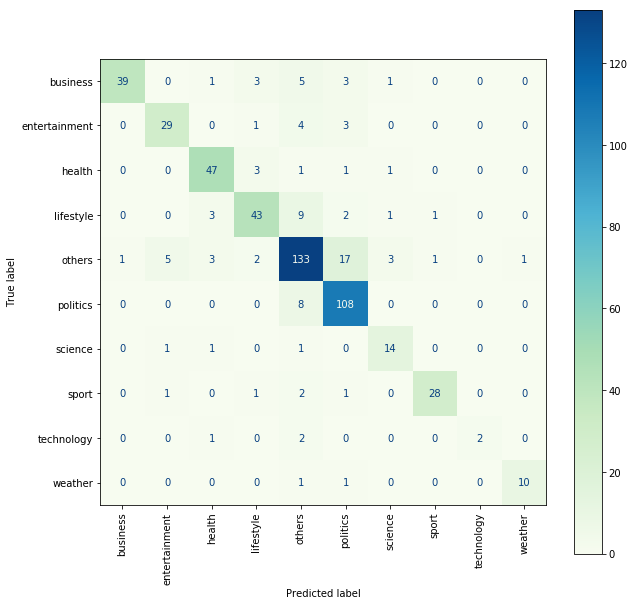

In [18]:
fig, ax = plt.subplots(figsize=(10,10))

label = ['business', 'entertainment', 'health', 'lifestyle', 'others', 'politics', 'science', 'sport', 'technology', 'weather']

plotted_confusion_matrix = plot_confusion_matrix(tweet_clf, test_data_temp['text'], test_data_temp['category'], normalize=None, values_format='d', xticks_rotation='vertical', cmap='GnBu', ax=ax)
precision = precision_score(test_data_temp['category'], predicted_temp, average=None)
recall = recall_score(test_data_temp['category'], predicted_temp, average=None)
f1 = f1_score(test_data_temp['category'], predicted_temp, average=None)
accuracy = accuracy_score(test_data_temp['category'], predicted_temp)

d = {"Precision": precision, "Recall": recall, "F1 Score": f1}
calculation_table = pd.DataFrame(data=d, index=label)

print(calculation_table)
print("Accuracy: ", accuracy * 100 ,"%")
print("Confusion matrix:")
plt.show()

Save the model

In [ ]:
pickle.dump(tweet_clf, open("model.pkl", "wb"))